# Load data

In [1]:
!wget -O Data.npz https://zenodo.org/record/4269852/files/dermamnist.npz?download=1

--2021-08-16 17:38:41--  https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19725078 (19M) [application/octet-stream]
Saving to: ‘Data.npz’

Data.npz            100%[===================>]  18.81M  2.72MB/s    in 15s     

2021-08-16 17:38:59 (1.22 MB/s) - ‘Data.npz’ saved [19725078/19725078]



In [2]:
import matplotlib.pyplot as plt   
import numpy as np
import matplotlib.image as mpimg
import cv2
from tensorflow.keras.utils import to_categorical
import operator

In [3]:
d = np.load('Data.npz')
print(d.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [4]:
print(d['train_labels'].shape)

(7007, 1)


Train: X=(7007, 28, 28, 3), y=(7007, 1)
Test: X=(2005, 28, 28, 3), y=(2005, 1)


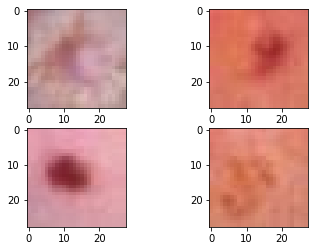

In [5]:
print('Train: X=%s, y=%s' % (d['train_images'].shape, d['train_labels'].shape))
print('Test: X=%s, y=%s' % (d['test_images'].shape, d['test_labels'].shape))
# plot some images
for i in range(4):
	plt.subplot(220 + 1 + i)
	plt.imshow(d['train_images'][i])
plt.show()

In [6]:
data = {key: d[key] for key in d.files}

In [7]:
data['train_images'][0].shape

(28, 28, 3)

# Preprocessing

In [8]:
# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

## Resize Images

In [9]:
# resize images
def resize_image(data):
    img = data
    print(len(img))
    print('Original size',img[0].shape)
    # setting dim of the resize
    height = 32
    width = 32
    dim = (width, height)
    res_img = []
    for i in range(len(img)):
        res = cv2.resize(img[i], dim, interpolation=cv2.INTER_LINEAR)
        res_img.append(res)

    # Checcking the size
    print("RESIZED", res_img[0].shape)
    
    # Visualizing one of the images in the array
    original = res_img[0]
    display_one(original)

    return np.array(res_img)

7007
Original size (28, 28, 3)
RESIZED (32, 32, 3)


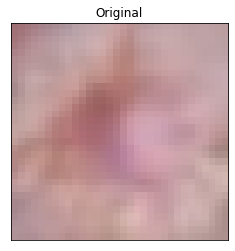

1003
Original size (28, 28, 3)
RESIZED (32, 32, 3)


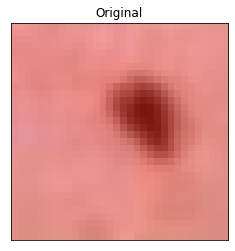

2005
Original size (28, 28, 3)
RESIZED (32, 32, 3)


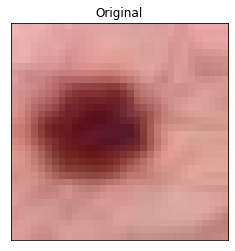

In [10]:
# Resize all images
data = dict({key: resize_image(data[key]) for key in d.files[:3]}, **{key: data[key] for key in d.files[3:]})

In [11]:
data['val_images'][6].shape

(32, 32, 3)

# Concat train, val and test, then shuffle and split

In [12]:
combined_images = np.concatenate([data['train_images'], data['val_images'], data['test_images']])
combined_labels = np.concatenate([data['train_labels'], data['val_labels'], data['test_labels']])

original_size = combined_images.shape[0]

In [13]:
combined_images.shape

(10015, 32, 32, 3)

In [14]:
c = np.c_[combined_images.reshape(len(combined_images), -1), combined_labels.reshape(len(combined_labels), -1)]

In [15]:
np.random.shuffle(c)

In [16]:
shuffled_images = c[:, :combined_images.size//len(combined_images)].reshape(combined_images.shape)
shuffled_labels = c[:, combined_images.size//len(combined_images):].reshape(combined_labels.shape)

In [17]:
shuffled_images.shape

(10015, 32, 32, 3)

In [18]:
shuffled_labels.shape

(10015, 1)

[1]


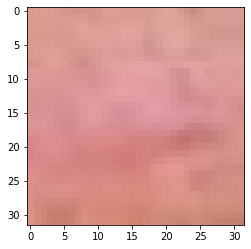

In [19]:
plt.imshow(shuffled_images[0])
print(shuffled_labels[0])

## Oversampling

# Image Data Generator

In [20]:
from keras.preprocessing.image import ImageDataGenerator

In [21]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=10,
    height_shift_range=10,
    brightness_range=(1, 1.4),
    #shear_range=5,
    zoom_range=0.1,
    #fill_mode = 'wrap',
    horizontal_flip = True,
    vertical_flip = True,
    rescale = 1/255.,
    #validation_split=0.2,
)

In [22]:
from tqdm import tqdm

result = np.where(shuffled_labels == [6])
index_tmp = np.random.choice(result[0].shape[0], 4, replace=False)  
index = result[0][index_tmp]
shuffled_labels[index]
shuffled_images[index]

class_count = {}
new_images , new_labels = [], []

# count number of samples of each class 
for class_num in range(7):
  class_count[class_num] = np.count_nonzero(shuffled_labels == [class_num])

max_class_c = max(class_count.items(), key=operator.itemgetter(1))[1]
print(max_class_c)

for class_num, count in tqdm(class_count.items()):
  #print(count)
  result = np.where(shuffled_labels == [class_num])
  index_tmp = np.random.choice(result[0].shape[0], count, replace=False)  
  index = result[0][index_tmp]
  imgs = shuffled_images[index]
  lbls = shuffled_labels[index]

  #print(len(imgs), len(lbls))
  counter = 0
  diff = max_class_c - count
  train_gen = datagen.flow(imgs, lbls, batch_size=1)
  
  while counter < diff:
    #image = image.reshape((-1,) + image.shape)
    #train_gen = datagen.flow(image, [0], batch_size=1, shuffle=False)
    X, y = train_gen.next()
    new_images.append(np.array(X[0]))
    new_labels.append(y)

    counter += 1

6705


100%|██████████| 7/7 [00:32<00:00,  4.70s/it]


In [23]:
new_labels = np.array(new_labels).reshape(-1,1)
new_labels.shape

(36920, 1)

In [24]:
shuffled_labels.shape

(10015, 1)

In [25]:
# normalize to range 0-1
shuffled_images = shuffled_images/255.

In [26]:
# combine new data with older ones
combined_images = np.concatenate([shuffled_images, np.array(new_images)])
combined_labels = np.concatenate([shuffled_labels, np.array(new_labels)])
c = np.c_[combined_images.reshape(len(combined_images), -1), combined_labels.reshape(len(combined_labels), -1)]
# shuffle 
np.random.shuffle(c)
# split
shuffled_images = c[:, :combined_images.size//len(combined_images)].reshape(combined_images.shape)
shuffled_labels = c[:, combined_images.size//len(combined_images):].reshape(combined_labels.shape)

In [28]:
print(shuffled_images.shape)
print(shuffled_labels.shape)

(46935, 32, 32, 3)
(46935, 1)


In [38]:
# split train, val and test
[data['train_images'], data['val_images'], data['test_images']] = np.split(shuffled_images, [int(.8 * len(shuffled_images)), int(.9 * len(shuffled_images))])
[data['train_labels'], data['val_labels'], data['test_labels']] = np.split(shuffled_labels, [int(.8 * len(shuffled_labels)), int(.9 * len(shuffled_labels))])

In [39]:
for tag in list(data.keys())[:3]:
  # convert from integers to floats
  data[tag] = data[tag].astype('float32')
  
# one hot y values
for tag in list(data.keys())[3:]:
  data[tag] = to_categorical(data[tag])

In [40]:
data['test_images'].shape

(4694, 32, 32, 3)

# Custom VGG Model

In [41]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *

In [42]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=data['train_images'][0].shape, kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform'))
model.add(MaxPool2D((4, 4), strides=(2, 2)))
model.add(Dropout(0.05))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(MaxPool2D((4, 4), strides=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))
model.add(MaxPool2D((4, 4), strides=(2, 2)))
model.add(Dropout(0.05))

model.add(Flatten())

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform'))
model.add(Dropout(0.05))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 128)        

In [43]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

In [44]:
data['train_images'].shape
data['train_labels'].shape

(37548, 7)

In [45]:
data['val_images'].shape
data['val_labels'].shape

(4693, 7)

In [46]:
history = model.fit(data['train_images'], data['train_labels'], batch_size=32, epochs=30, validation_data=(data['val_images'], data['val_labels']))

Epoch 1/30
1174/1174 [==============================] - 25s 20ms/step - loss: 1.8747 - acc: 0.3651 - val_loss: 1.4967 - val_acc: 0.5150
Epoch 2/30
1174/1174 [==============================] - 23s 20ms/step - loss: 1.4641 - acc: 0.5135 - val_loss: 1.3780 - val_acc: 0.5495
Epoch 3/30
1174/1174 [==============================] - 23s 20ms/step - loss: 1.3587 - acc: 0.5484 - val_loss: 1.2841 - val_acc: 0.5847
Epoch 4/30
1174/1174 [==============================] - 23s 20ms/step - loss: 1.2746 - acc: 0.5744 - val_loss: 1.2062 - val_acc: 0.5996
Epoch 5/30
1174/1174 [==============================] - 23s 20ms/step - loss: 1.2022 - acc: 0.6008 - val_loss: 1.1507 - val_acc: 0.6256
Epoch 6/30
1174/1174 [==============================] - 23s 20ms/step - loss: 1.1390 - acc: 0.6228 - val_loss: 1.1244 - val_acc: 0.6250
Epoch 7/30
1174/1174 [==============================] - 23s 20ms/step - loss: 1.0872 - acc: 0.6381 - val_loss: 1.0772 - val_acc: 0.6373
Epoch 8/30
1174/1174 [==========================

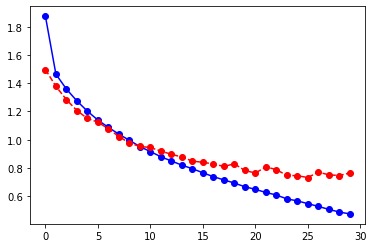

In [47]:
plt.plot(history.history['loss'], 'b-o')
plt.plot(history.history['val_loss'], 'r--o')

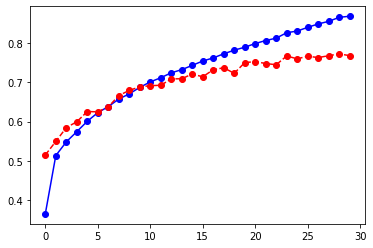

In [48]:
plt.plot(history.history['acc'], 'b-o')
plt.plot(history.history['val_acc'], 'r--o')

In [49]:
model.evaluate(data['test_images'], data['test_labels'])

147/147 [==============================] - 1s 10ms/step - loss: 0.7356 - acc: 0.7718


[0.7355631589889526, 0.7718364000320435]

[[563  94 112  12  96   7   0]
 [ 65 523  68  21  38  12   2]
 [ 41  35 355   9 149  18   0]
 [  3   5   5 597   9   0   0]
 [ 16  13  81   3 303  14   3]
 [  3   5  52   3  61 606   2]
 [  1   2   4   0   6   1 676]]


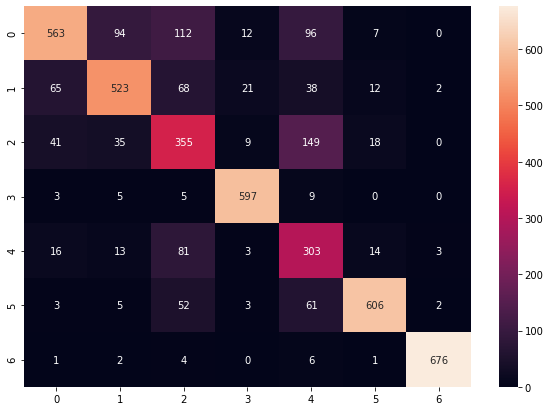

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import pandas as pd
import seaborn as sn


pred_test_values = np.argmax(model.predict(data['test_images']), axis=1)
y_test_arg = np.argmax(data['test_labels'], axis=1)

cm = confusion_matrix(pred_test_values, y_test_arg)
print(cm)

target_labels = '0123456'
df_cm = pd.DataFrame(cm, index = [i for i in target_labels],
                  columns = [i for i in target_labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

In [54]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(y_test_arg, pred_test_values, target_names=target_labels, digits=4))

              precision    recall  f1-score   support

           0     0.6369    0.8136    0.7145       692
           1     0.7174    0.7725    0.7440       677
           2     0.5848    0.5244    0.5530       677
           3     0.9645    0.9256    0.9446       645
           4     0.6998    0.4577    0.5534       662
           5     0.8279    0.9210    0.8719       658
           6     0.9797    0.9898    0.9847       683

    accuracy                         0.7718      4694
   macro avg     0.7730    0.7721    0.7666      4694
weighted avg     0.7715    0.7718    0.7657      4694



# Functional API

In [55]:
# parameters for the network
input_shape = data['train_images'][0].shape
batch_size = 32
kernel_size = 3
filters = [64, 128, 32]
dropout = 0.05
num_labels = 7

In [62]:
# import libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

# utiliaing functional API to build cnn layers
inputs = Input(shape=input_shape)
y = Conv2D(filters=filters[0], kernel_size=kernel_size, activation='relu', padding='same', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform')(inputs)
y = AveragePooling2D((4, 4), strides=(2, 2))(y)
y = Dropout(dropout)(y)
y = Conv2D(filters=filters[0], kernel_size=kernel_size, activation='tanh', padding='same', kernel_initializer='he_uniform')(y)
y = AveragePooling2D((4, 4), strides=(2, 2))(y)
y = Conv2D(filters=filters[1], kernel_size=kernel_size, activation='tanh', padding='same', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform')(y)
y = AveragePooling2D((4, 4), strides=(2, 2))(y)
y = Conv2D(filters=filters[0], kernel_size=kernel_size, activation='relu', padding='same', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform')(y)
y = Conv2D(filters=filters[0], kernel_size=kernel_size, activation='sigmoid', padding='same', kernel_initializer='he_uniform')(y)
y = Conv2D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform')(y)
y = Conv2D(filters=filters[1], kernel_size=kernel_size, activation='relu', padding='same', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform')(y)
# Convert image to vector 
y = Flatten()(y)

# Dropout regularization
y = Dropout(dropout)(y)
outputs = Dense(num_labels, activation='softmax')(y)

# model building by supplying inputs/outputs
model = Model(inputs=inputs, outputs=outputs)

In [64]:
model.compile(loss='categorical_crossentropy',
	 optimizer=Adam(learning_rate=0.001),
	 metrics=['accuracy'])
model.fit(data['train_images'], 
data['train_labels'],
  validation_data=(data['val_images'], data['val_labels']),
  epochs=30,
  batch_size=batch_size)

Epoch 1/30
1174/1174 [==============================] - 16s 13ms/step - loss: 1.6121 - accuracy: 0.3828 - val_loss: 1.3662 - val_accuracy: 0.4877
Epoch 2/30
1174/1174 [==============================] - 14s 12ms/step - loss: 1.3503 - accuracy: 0.4837 - val_loss: 1.2696 - val_accuracy: 0.5154
Epoch 3/30
1174/1174 [==============================] - 14s 12ms/step - loss: 1.2735 - accuracy: 0.5112 - val_loss: 1.2882 - val_accuracy: 0.5078
Epoch 4/30
1174/1174 [==============================] - 14s 12ms/step - loss: 1.2249 - accuracy: 0.5328 - val_loss: 1.2107 - val_accuracy: 0.5351
Epoch 5/30
1174/1174 [==============================] - 14s 12ms/step - loss: 1.1870 - accuracy: 0.5477 - val_loss: 1.1936 - val_accuracy: 0.5451
Epoch 6/30
1174/1174 [==============================] - 14s 12ms/step - loss: 1.1567 - accuracy: 0.5601 - val_loss: 1.1442 - val_accuracy: 0.5698
Epoch 7/30
1174/1174 [==============================] - 14s 12ms/step - loss: 1.1399 - accuracy: 0.5689 - val_loss: 1.1467 -

In [65]:
# accuracy evaluation
score = model.evaluate(data['test_images'], data['test_labels'],
  batch_size=batch_size,
  verbose=0)
print("Test Accuracy: %.1f%%" % (100.0 * score[1]))

Test Accuracy: 67.6%


[[359  59  63  22  76   1   2]
 [147 468 112  68  65  10  13]
 [ 45  20 212   7  51  15   0]
 [ 73  57  40 526  27   2   1]
 [ 56  39 181  13 357  35   4]
 [  9   7  49   5  66 591   4]
 [  3  27  20   4  20   4 659]]


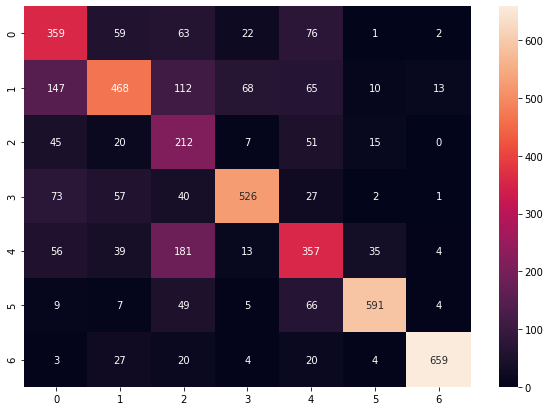

In [68]:
pred_test_values = np.argmax(model.predict(data['test_images']), axis=1)
y_test_arg = np.argmax(data['test_labels'], axis=1)
cm = confusion_matrix(pred_test_values, y_test_arg)
print(cm)
target_labels = '0123456'
df_cm = pd.DataFrame(cm, index = [i for i in target_labels], columns = [i for i in target_labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

# Run wihtout preprocessing

In [82]:
d = np.load('Data.npz')
data = {key: d[key] for key in d.files}

In [84]:
# one hot y values
for tag in list(data.keys())[3:]:
  data[tag] = to_categorical(data[tag], num_classes=7)

In [85]:
data['val_labels'][0]

array([0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [86]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=data['train_images'][0].shape, kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform'))
model.add(MaxPool2D((4, 4), strides=(2, 2)))
model.add(Dropout(0.05))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(MaxPool2D((4, 4), strides=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))
model.add(MaxPool2D((4, 4), strides=(2, 2)))
model.add(Dropout(0.05))

model.add(Flatten())

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform'))
model.add(Dropout(0.05))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 28, 28, 64)        1792      
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 13, 13, 128)       147584    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 5, 128)        

In [87]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(data['train_images'], data['train_labels'], batch_size=32, epochs=30, validation_data=(data['val_images'], data['val_labels']))

Epoch 1/30
219/219 [==============================] - 50s 21ms/step - loss: 34.1726 - acc: 0.5022 - val_loss: 2.6228 - val_acc: 0.6620
Epoch 2/30
219/219 [==============================] - 4s 18ms/step - loss: 3.7564 - acc: 0.5362 - val_loss: 1.6498 - val_acc: 0.5244
Epoch 3/30
219/219 [==============================] - 4s 18ms/step - loss: 1.9570 - acc: 0.5544 - val_loss: 1.4051 - val_acc: 0.6022
Epoch 4/30
219/219 [==============================] - 4s 18ms/step - loss: 1.6448 - acc: 0.5867 - val_loss: 1.4070 - val_acc: 0.5663
Epoch 5/30
219/219 [==============================] - 4s 18ms/step - loss: 1.5191 - acc: 0.6075 - val_loss: 1.3540 - val_acc: 0.6471
Epoch 6/30
219/219 [==============================] - 4s 18ms/step - loss: 1.4444 - acc: 0.6287 - val_loss: 1.3371 - val_acc: 0.6311
Epoch 7/30
219/219 [==============================] - 4s 18ms/step - loss: 1.4156 - acc: 0.6329 - val_loss: 1.3080 - val_acc: 0.6411
Epoch 8/30
219/219 [==============================] - 4s 18ms/step 

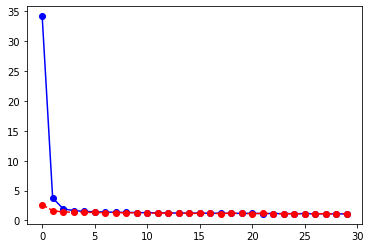

In [89]:
plt.plot(history.history['loss'], 'b-o')
plt.plot(history.history['val_loss'], 'r--o')

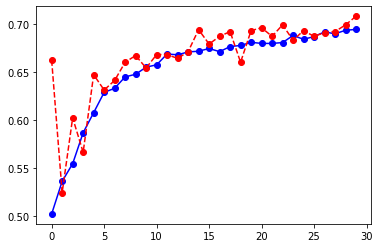

In [91]:
plt.plot(history.history['acc'], 'b-o')
plt.plot(history.history['val_acc'], 'r--o')

## همانطور که مشخص است هیچ پیشرفت قابل توجهی حاصل نشده است و همچنین دقت حاصل نیز به دلیل این که داده ها بالانس نشده هستند دقت واقعی نیست.

[[   9    3   10    0    4    1    0]
 [  24   33   32    5    9   18    2]
 [  11   35   63   12   20   51    2]
 [   0    0    0    0    0    0    0]
 [  13   12   24    1   64   29    7]
 [   9   19   91    5  123 1235    7]
 [   0    1    0    0    3    7   11]]


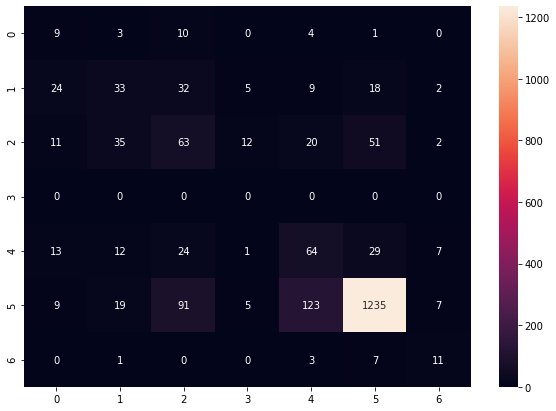

In [92]:
pred_test_values = np.argmax(model.predict(data['test_images']), axis=1)
y_test_arg = np.argmax(data['test_labels'], axis=1)
cm = confusion_matrix(pred_test_values, y_test_arg)
print(cm)
target_labels = '0123456'
df_cm = pd.DataFrame(cm, index = [i for i in target_labels], columns = [i for i in target_labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

In [93]:
print(classification_report(y_test_arg, pred_test_values, target_names=target_labels, digits=4))

              precision    recall  f1-score   support

           0     0.3333    0.1364    0.1935        66
           1     0.2683    0.3204    0.2920       103
           2     0.3247    0.2864    0.3043       220
           3     0.0000    0.0000    0.0000        23
           4     0.4267    0.2870    0.3432       223
           5     0.8294    0.9210    0.8728      1341
           6     0.5000    0.3793    0.4314        29

    accuracy                         0.7057      2005
   macro avg     0.3832    0.3329    0.3482      2005
weighted avg     0.6698    0.7057    0.6829      2005



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## همانطور که از نمودارهای بالا مشخص است تنها نتایج کلاس 5 به دلایلی که در گزارش ذکر شده است خوب است و بقیه ی کلاس ها نتایج بدی داشته اند و این اهمیت پیش پردازش و تمامی کارهایی که به تفصیل در گزارش ذکر شده و انجام شده اند را نشان می دهد.